In [13]:
%run change_data.py

Processing chunk starting at index 0
Processing chunk starting at index 1000
Processing chunk starting at index 2000
Processing chunk starting at index 3000
Processing chunk starting at index 4000
Processing chunk starting at index 5000
Processing chunk starting at index 6000
Processing chunk starting at index 7000
Processing chunk starting at index 8000
Processing chunk starting at index 9000
Processing chunk starting at index 10000
Processing chunk starting at index 11000
Processing chunk starting at index 12000
Processing chunk starting at index 13000
Processing chunk starting at index 14000
Processing chunk starting at index 15000
Processing chunk starting at index 16000
Processing chunk starting at index 17000
Processing chunk starting at index 18000
Processing chunk starting at index 19000
Processing chunk starting at index 20000
Processing chunk starting at index 21000
Processing chunk starting at index 22000
Processing chunk starting at index 23000
Processing chunk starting at 

Expression matrix shape: (37779, 307)
Metadata shape: (307, 23)
Aligned expression matrix shape: (37779, 307)
Groups: group
Control    154
Stress     153
Name: count, dtype: int64
Control samples: 154
Stress samples: 153
Total genes analyzed: 37779
Significant genes (padj < 0.05): 31
Significant genes with |log2FC| >= 1.0: 0
Saved: results\DE_results.csv
Saved: results\top_50_DEGs.csv

Top 10 differentially expressed genes:
               log2fc  pvalue    padj  mean_control  mean_stress
gene                                                            
Slc16a13      -0.2858     0.0  0.0061        2.8286       2.3200
Mbnl2         -0.1008     0.0  0.0061       29.4441      27.4572
Gm42536        0.7122     0.0  0.0114        0.3036       0.4980
Gm16794       -0.3475     0.0  0.0114        1.9128       1.5031
2610307P16Rik -0.7240     0.0  0.0114        1.3596       0.8227
Actg1         -0.0611     0.0  0.0122       75.3570      72.2297
Cfl1          -0.0701     0.0  0.0122       47.2463 

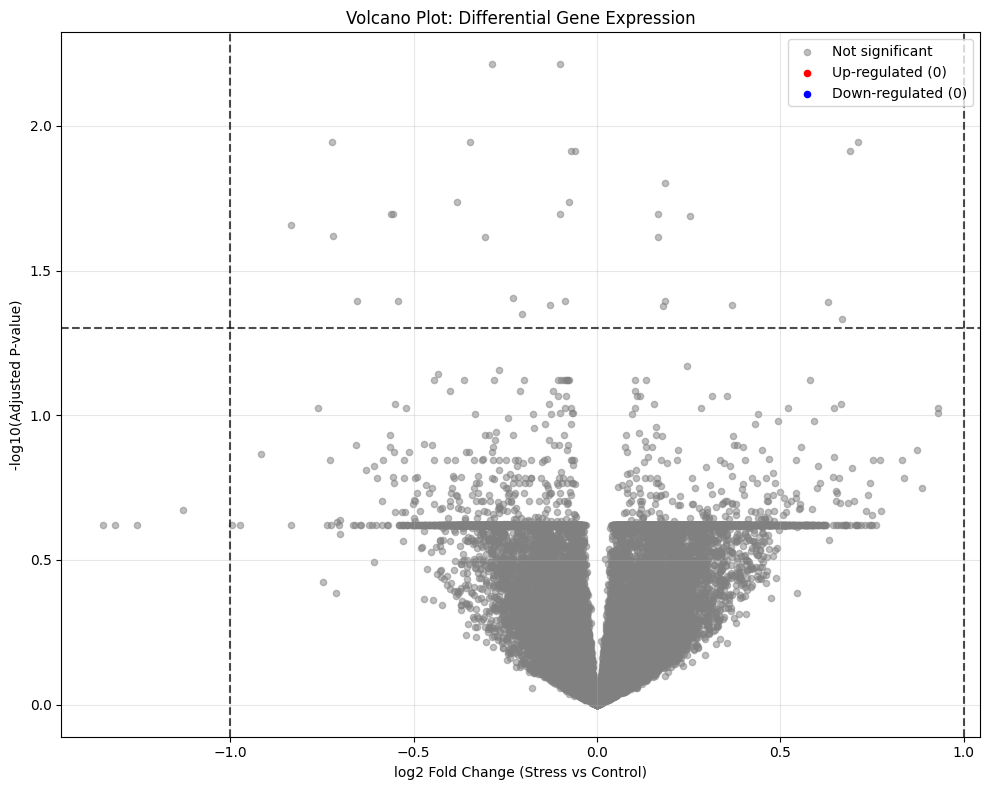

Saved: results\volcano_plot.png
No genes passed both thresholds; using top 20 by p-value for heatmap.
Creating heatmap with 20 genes


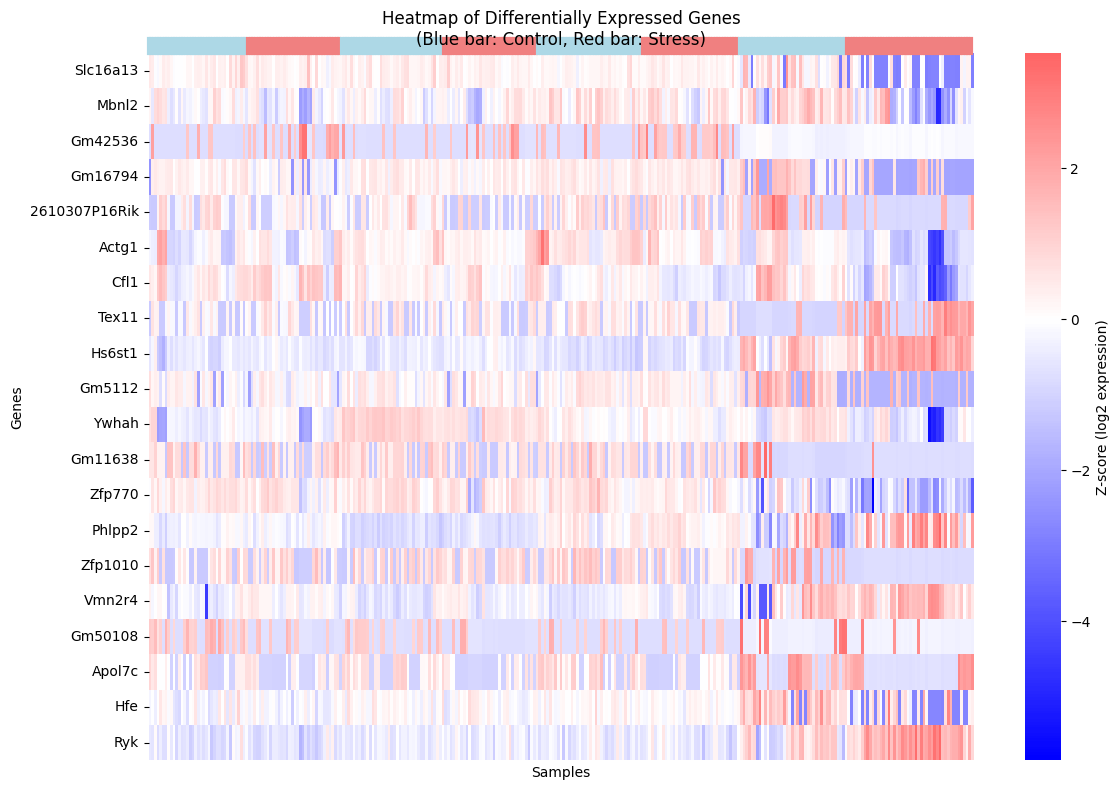

Saved: results\heatmap_significant_genes.png

=== SUMMARY ===
Total genes analyzed: 37779
Genes with padj < 0.05: 31
Up-regulated genes (padj < 0.05, log2FC >= 1.0): 0
Down-regulated genes (padj < 0.05, log2FC <= -1.0): 0
Results saved to: results/


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from scipy.stats import ttest_ind
import seaborn as sns

# --- CONFIG ---
RESULTS_DIR = "results"
FC_CUTOFF = 1.0         # |log2FC| threshold
PADJ_CUTOFF = 0.05
TOP_N = 50

Path(RESULTS_DIR).mkdir(exist_ok=True, parents=True)

# --- Load the data (same as in Part 2) ---
df = pd.read_csv("gene.tsv", sep='\t', index_col=0)
metadata = pd.read_csv("SRP181622/metadata_SRP181622.tsv", sep='\t', index_col=0)

print(f"Expression matrix shape: {df.shape}")
print(f"Metadata shape: {metadata.shape}")

# --- Create sample groups based on your Part 2 logic ---
sample_type = []
sample_names = []

for sample in metadata.index:
    if sample in df.columns:
        sample_names.append(sample)
        if 'Control' in metadata['refinebio_title'][sample]:
            sample_type.append('Control')
        else:
            sample_type.append('Stress')

# Create a metadata dataframe aligned with expression data
meta_aligned = pd.DataFrame({
    'sample': sample_names,
    'group': sample_type
}).set_index('sample')

# Align expression data to only include samples we have metadata for
expr = df[sample_names].copy()

print(f"Aligned expression matrix shape: {expr.shape}")
print(f"Groups: {meta_aligned['group'].value_counts()}")

REF_LEVEL = "Control"
CASE_LEVEL = "Stress"

# --- Prepare data for differential expression ---
# Get samples for each group
control_samples = meta_aligned[meta_aligned['group'] == REF_LEVEL].index.tolist()
stress_samples = meta_aligned[meta_aligned['group'] == CASE_LEVEL].index.tolist()

print(f"Control samples: {len(control_samples)}")
print(f"Stress samples: {len(stress_samples)}")

# --- Perform t-tests for each gene ---
results = []

for gene in expr.index:
    control_values = expr.loc[gene, control_samples].values
    stress_values = expr.loc[gene, stress_samples].values
    
    # Remove any NaN values
    control_values = control_values[~np.isnan(control_values)]
    stress_values = stress_values[~np.isnan(stress_values)]
    
    if len(control_values) > 1 and len(stress_values) > 1:
        # Perform t-test
        stat, pvalue = ttest_ind(stress_values, control_values, equal_var=False)
        
        # Calculate fold change (log2)
        mean_control = np.mean(control_values)
        mean_stress = np.mean(stress_values)
        
        # Add small constant to avoid log(0)
        log2fc = np.log2((mean_stress + 0.001) / (mean_control + 0.001))
        
        results.append({
            'gene': gene,
            'log2fc': log2fc,
            'pvalue': pvalue,
            'mean_control': mean_control,
            'mean_stress': mean_stress
        })

# Convert to DataFrame
res = pd.DataFrame(results)
res = res.set_index('gene')

# --- Apply Benjamini-Hochberg correction ---
from scipy.stats import false_discovery_control

# Handle any NaN p-values
res = res.dropna(subset=['pvalue'])

# Apply FDR correction
res['padj'] = false_discovery_control(res['pvalue'], method='bh')

# Sort by adjusted p-value
res = res.sort_values('padj')

print(f"Total genes analyzed: {len(res)}")
print(f"Significant genes (padj < {PADJ_CUTOFF}): {sum(res['padj'] < PADJ_CUTOFF)}")
print(f"Significant genes with |log2FC| >= {FC_CUTOFF}: {sum((res['padj'] < PADJ_CUTOFF) & (res['log2fc'].abs() >= FC_CUTOFF))}")

# --- Save results ---
full_path = os.path.join(RESULTS_DIR, "DE_results.csv")
res.to_csv(full_path)
print(f"Saved: {full_path}")

# --- Top N table ---
topN = res.head(TOP_N)
top_path = os.path.join(RESULTS_DIR, f"top_{TOP_N}_DEGs.csv")
topN.to_csv(top_path)
print(f"Saved: {top_path}")

# Display top 10 results
print("\nTop 10 differentially expressed genes:")
print(topN.head(10)[['log2fc', 'pvalue', 'padj', 'mean_control', 'mean_stress']].round(4))

# --- Volcano plot ---
x = res['log2fc']
y = -np.log10(res['padj'].clip(lower=1e-300))  # Avoid log(0)

# Define significant genes
sig = (res['padj'] < PADJ_CUTOFF) & (res['log2fc'].abs() >= FC_CUTOFF)
up_reg = (res['padj'] < PADJ_CUTOFF) & (res['log2fc'] >= FC_CUTOFF)
down_reg = (res['padj'] < PADJ_CUTOFF) & (res['log2fc'] <= -FC_CUTOFF)

plt.figure(figsize=(10, 8))
plt.scatter(x[~sig], y[~sig], s=20, alpha=0.5, color='gray', label='Not significant')
plt.scatter(x[up_reg], y[up_reg], s=20, color='red', label=f'Up-regulated ({sum(up_reg)})')
plt.scatter(x[down_reg], y[down_reg], s=20, color='blue', label=f'Down-regulated ({sum(down_reg)})')

plt.axvline(FC_CUTOFF, color='black', linestyle='--', alpha=0.7)
plt.axvline(-FC_CUTOFF, color='black', linestyle='--', alpha=0.7)
plt.axhline(-np.log10(PADJ_CUTOFF), color='black', linestyle='--', alpha=0.7)

plt.xlabel('log2 Fold Change (Stress vs Control)')
plt.ylabel('-log10(Adjusted P-value)')
plt.title('Volcano Plot: Differential Gene Expression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

volcano_path = os.path.join(RESULTS_DIR, "volcano_plot.png")
plt.savefig(volcano_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {volcano_path}")

# --- Heatmap of top significant genes ---
sig_genes = res.index[(res['padj'] < PADJ_CUTOFF) & (res['log2fc'].abs() >= FC_CUTOFF)].tolist()

if len(sig_genes) == 0:
    print("No genes passed both thresholds; using top 20 by p-value for heatmap.")
    sig_genes = res.head(20).index.tolist()

if len(sig_genes) > 50:
    sig_genes = sig_genes[:50]  # Limit to top 50 for readability

print(f"Creating heatmap with {len(sig_genes)} genes")

# Prepare data for heatmap
heatmap_data = expr.loc[sig_genes, sample_names].copy()

# Log transform and z-score normalize
heatmap_data_log = np.log2(heatmap_data + 1)
heatmap_data_zscore = heatmap_data_log.T.apply(lambda x: (x - x.mean()) / x.std(), axis=0).T

# Create annotation for samples
sample_colors = {'Control': 'lightblue', 'Stress': 'lightcoral'}
col_colors = [sample_colors[meta_aligned.loc[sample, 'group']] for sample in sample_names]

# Create heatmap
plt.figure(figsize=(12, max(8, len(sig_genes) * 0.3)))

# Create a custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ['blue', 'white', 'red']
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Plot heatmap
sns.heatmap(heatmap_data_zscore, 
            cmap=cmap, 
            center=0,
            xticklabels=False,
            yticklabels=True,
            cbar_kws={'label': 'Z-score (log2 expression)'})

# Add sample group annotation at the top
for i, color in enumerate(col_colors):
    plt.axvline(i, ymax=1.02, ymin=1.00, color=color, linewidth=3, clip_on=False)

plt.title('Heatmap of Differentially Expressed Genes\n(Blue bar: Control, Red bar: Stress)')
plt.xlabel('Samples')
plt.ylabel('Genes')
plt.tight_layout()

heatmap_path = os.path.join(RESULTS_DIR, "heatmap_significant_genes.png")
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {heatmap_path}")

# --- Summary statistics ---
print(f"\n=== SUMMARY ===")
print(f"Total genes analyzed: {len(res)}")
print(f"Genes with padj < {PADJ_CUTOFF}: {sum(res['padj'] < PADJ_CUTOFF)}")
print(f"Up-regulated genes (padj < {PADJ_CUTOFF}, log2FC >= {FC_CUTOFF}): {sum(up_reg)}")
print(f"Down-regulated genes (padj < {PADJ_CUTOFF}, log2FC <= -{FC_CUTOFF}): {sum(down_reg)}")
print(f"Results saved to: {RESULTS_DIR}/")

C:\Users\Jess\AppData\Local\Temp\ipykernel_42328\4220241050.py:76: DeprecationWarning: processes is deprecated; use threads
  gsea = gp.prerank(
2025-09-25 21:22:37,202 [WARNING] Duplicated values found in preranked stats: 11.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Loaded 37779 genes from DE analysis
Significant genes: 0
Too few significant genes, relaxing padj threshold to 0.1
New total: 80 genes
Using 80 genes for enrichment analysis
Running Over-Representation Analysis (ORA)...
  Analyzing GO_Biological_Process_2023...
Error in Enrichr analysis for GO_Biological_Process_2023: enrichr() got an unexpected keyword argument 'description'
    No significant results for GO_Biological_Process_2023
  Analyzing GO_Molecular_Function_2023...
Error in Enrichr analysis for GO_Molecular_Function_2023: enrichr() got an unexpected keyword argument 'description'
    No significant results for GO_Molecular_Function_2023
  Analyzing GO_Cellular_Component_2023...
Error in Enrichr analysis for GO_Cellular_Component_2023: enrichr() got an unexpected keyword argument 'description'
    No significant results for GO_Cellular_Component_2023
  Analyzing KEGG_2021_Human...
Error in Enrichr analysis for KEGG_2021_Human: enrichr() got an unexpected keyword argument 'descr

C:\Users\Jess\AppData\Local\Temp\ipykernel_42328\4220241050.py:76: DeprecationWarning: processes is deprecated; use threads
  gsea = gp.prerank(
2025-09-25 21:25:09,996 [WARNING] Duplicated values found in preranked stats: 11.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


    Found 403 significant terms, saved to results\enrichment_gseapy\GSEA_GO_Biological_Process_2023.csv
  Analyzing KEGG_2021_Human...
    Found 82 significant terms, saved to results\enrichment_gseapy\GSEA_KEGG_2021_Human.csv
  Analyzing MSigDB_Hallmark_2020...


C:\Users\Jess\AppData\Local\Temp\ipykernel_42328\4220241050.py:76: DeprecationWarning: processes is deprecated; use threads
  gsea = gp.prerank(
2025-09-25 21:25:43,775 [WARNING] Duplicated values found in preranked stats: 11.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


    Found 21 significant terms, saved to results\enrichment_gseapy\GSEA_MSigDB_Hallmark_2020.csv
Saved comprehensive summary: results\enrichment_gseapy\comprehensive_enrichment_summary.csv


C:\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jess\AppData\Roaming\Python\Python312\site-packages\matplotlib\transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
C:\Users\Jess\AppData\Roaming\Python\Python312\site-packages\matplotlib\transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


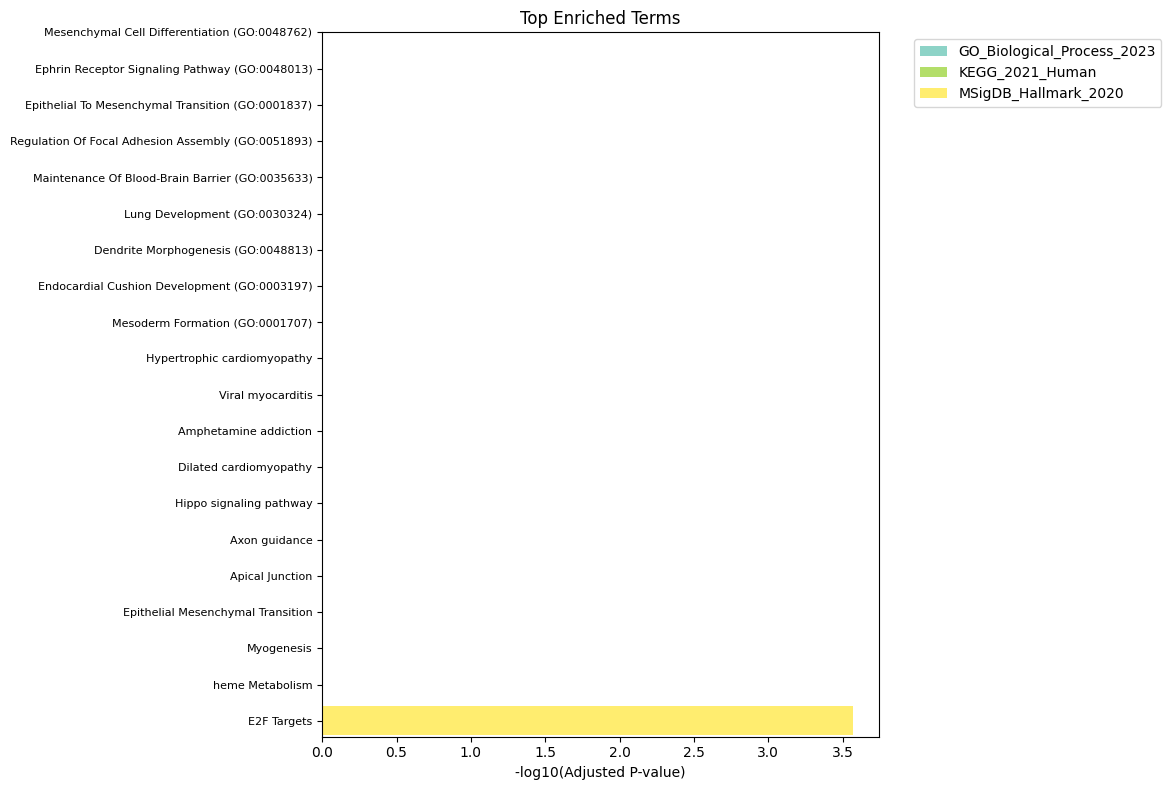

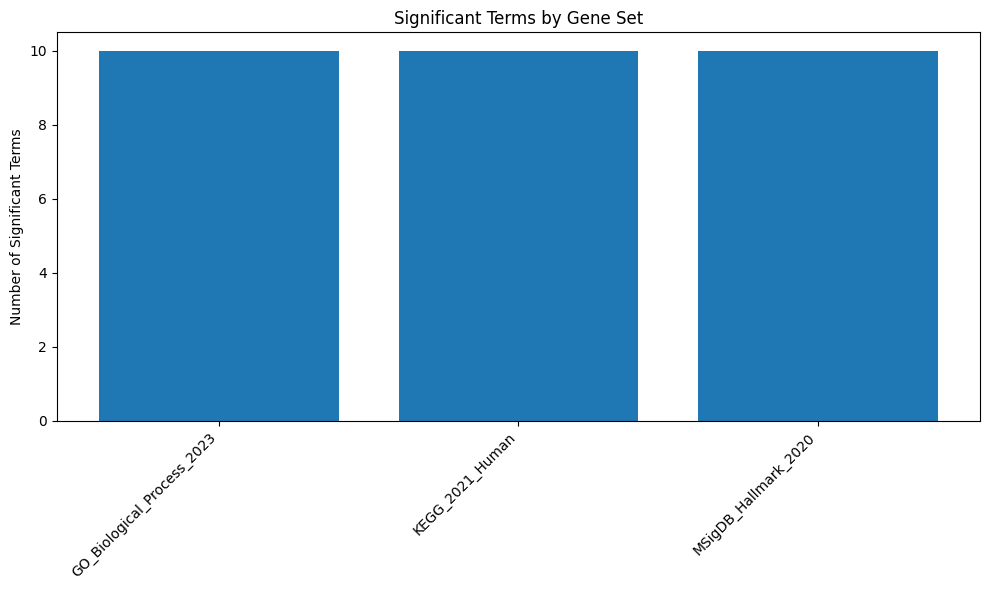


=== TOP ENRICHMENT RESULTS ===
Method: GSEApy (Over-Representation Analysis + GSEA)
Ontologies: GO, KEGG, WikiPathways, Reactome, MSigDB Hallmarks
Input genes: 80 significant DE genes

[GSEA] GO_Biological_Process_2023: Mesenchymal Cell Differentiation (GO:0048762)...
    P-adj: 0.00e+00, Genes: 0

[GSEA] GO_Biological_Process_2023: Ephrin Receptor Signaling Pathway (GO:0048013)...
    P-adj: 0.00e+00, Genes: 0

[GSEA] GO_Biological_Process_2023: Epithelial To Mesenchymal Transition (GO:0001837)...
    P-adj: 0.00e+00, Genes: 0

[GSEA] GO_Biological_Process_2023: Regulation Of Focal Adhesion Assembly (GO:0051893)...
    P-adj: 0.00e+00, Genes: 0

[GSEA] GO_Biological_Process_2023: Maintenance Of Blood-Brain Barrier (GO:0035633)...
    P-adj: 0.00e+00, Genes: 0

[GSEA] GO_Biological_Process_2023: Lung Development (GO:0030324)...
    P-adj: 0.00e+00, Genes: 0

[GSEA] GO_Biological_Process_2023: Dendrite Morphogenesis (GO:0048813)...
    P-adj: 0.00e+00, Genes: 0

[GSEA] GO_Biological_Pr

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Install GSEApy if not already installed
try:
    import gseapy as gp
except ImportError:
    print("Installing GSEApy...")
    os.system("pip install gseapy")
    import gseapy as gp

# Load your differential expression results
RESULTS_DIR = "results"
results_file = os.path.join(RESULTS_DIR, "DE_results.csv")

if not os.path.exists(results_file):
    print(f"Please run the differential expression analysis first to generate {results_file}")
    exit()

de_results = pd.read_csv(results_file, index_col=0)
print(f"Loaded {len(de_results)} genes from DE analysis")

# Create output directory
enrichment_dir = os.path.join(RESULTS_DIR, "enrichment_gseapy")
Path(enrichment_dir).mkdir(exist_ok=True, parents=True)

# Define significance thresholds
PADJ_CUTOFF = 0.05
FC_CUTOFF = 1.0

# Extract significantly differentially expressed genes
sig_genes = de_results[
    (de_results['padj'] < PADJ_CUTOFF) & 
    (de_results['log2fc'].abs() >= FC_CUTOFF)
].index.tolist()

print(f"Significant genes: {len(sig_genes)}")

# If we have too few significant genes, relax the criteria
if len(sig_genes) < 10:
    print("Too few significant genes, relaxing padj threshold to 0.1")
    sig_genes = de_results[de_results['padj'] < 0.1].index.tolist()
    print(f"New total: {len(sig_genes)} genes")

if len(sig_genes) == 0:
    print("No significant genes found, using top 100 by p-value")
    sig_genes = de_results.nsmallest(100, 'pvalue').index.tolist()

print(f"Using {len(sig_genes)} genes for enrichment analysis")

# Method 1: Over-Representation Analysis (ORA) using Enrichr
def run_enrichr_analysis(genes, gene_sets, description=""):
    """Run over-representation analysis using Enrichr"""
    try:
        enr = gp.enrichr(
            gene_list=genes,
            gene_sets=gene_sets,
            organism='human',
            description=description,
            outdir=None,  # Don't save intermediate files
            cutoff=0.05
        )
        return enr.results
    except Exception as e:
        print(f"Error in Enrichr analysis for {gene_sets}: {e}")
        return None

# Method 2: Gene Set Enrichment Analysis (GSEA) using ranked gene list
def run_gsea_analysis(gene_ranking, gene_sets, description=""):
    """Run GSEA using ranked gene list"""
    try:
        gsea = gp.prerank(
            rnk=gene_ranking,
            gene_sets=gene_sets,
            processes=4,
            outdir=None,
            format='png',
            seed=6
        )
        return gsea.res2d
    except Exception as e:
        print(f"Error in GSEA analysis for {gene_sets}: {e}")
        return None

# Prepare gene ranking for GSEA (all genes ranked by signed p-value)
de_results['signed_pvalue'] = -np.log10(de_results['pvalue']) * np.sign(de_results['log2fc'])
gene_ranking = de_results[['signed_pvalue']].copy()
gene_ranking = gene_ranking.sort_values('signed_pvalue', ascending=False)

# Define gene sets to analyze
gene_sets_to_analyze = [
    'GO_Biological_Process_2023',
    'GO_Molecular_Function_2023', 
    'GO_Cellular_Component_2023',
    'KEGG_2021_Human',
    'WikiPathway_2023_Human',
    'Reactome_2022',
    'MSigDB_Hallmark_2020'
]

enrichment_results = {}

print("Running Over-Representation Analysis (ORA)...")
# Run ORA for each gene set
for gene_set in gene_sets_to_analyze:
    print(f"  Analyzing {gene_set}...")
    results = run_enrichr_analysis(sig_genes, gene_set, f"ORA_{gene_set}")
    if results is not None and len(results) > 0:
        enrichment_results[f"ORA_{gene_set}"] = results
        
        # Save individual results
        output_file = os.path.join(enrichment_dir, f"ORA_{gene_set}.csv")
        results.to_csv(output_file, index=False)
        print(f"    Found {len(results)} significant terms, saved to {output_file}")
    else:
        print(f"    No significant results for {gene_set}")

print("\nRunning Gene Set Enrichment Analysis (GSEA)...")
# Run GSEA for selected gene sets (fewer because it's computationally intensive)
gsea_gene_sets = [
    'GO_Biological_Process_2023',
    'KEGG_2021_Human',
    'MSigDB_Hallmark_2020'
]

for gene_set in gsea_gene_sets:
    print(f"  Analyzing {gene_set}...")
    results = run_gsea_analysis(gene_ranking, gene_set, f"GSEA_{gene_set}")
    if results is not None and len(results) > 0:
        # Filter significant results
        sig_results = results[results['FDR q-val'] < 0.05]
        if len(sig_results) > 0:
            enrichment_results[f"GSEA_{gene_set}"] = sig_results
            
            # Save results
            output_file = os.path.join(enrichment_dir, f"GSEA_{gene_set}.csv")
            sig_results.to_csv(output_file, index=False)
            print(f"    Found {len(sig_results)} significant terms, saved to {output_file}")
        else:
            print(f"    No significant results for {gene_set}")
    else:
        print(f"    No results for {gene_set}")

# Create comprehensive summary table
def create_comprehensive_summary():
    """Create a comprehensive summary of all enrichment results"""
    all_results = []
    
    for analysis_name, results_df in enrichment_results.items():
        method, gene_set = analysis_name.split('_', 1)
        
        if method == 'ORA':
            # Enrichr results
            for _, row in results_df.head(10).iterrows():
                all_results.append({
                    'Method': 'Over-Representation Analysis (Enrichr)',
                    'Gene_Set': gene_set,
                    'Term': row.get('Term', ''),
                    'P_value': row.get('P-value', 1),
                    'Adjusted_P_value': row.get('Adjusted P-value', 1),
                    'Combined_Score': row.get('Combined Score', 0),
                    'Genes': row.get('Genes', ''),
                    'Gene_Count': len(str(row.get('Genes', '')).split(';')) if row.get('Genes') else 0
                })
        
        elif method == 'GSEA':
            # GSEA results
            for _, row in results_df.head(10).iterrows():
                all_results.append({
                    'Method': 'Gene Set Enrichment Analysis (GSEA)',
                    'Gene_Set': gene_set,
                    'Term': row.get('Term', ''),
                    'P_value': row.get('NOM p-val', 1),
                    'Adjusted_P_value': row.get('FDR q-val', 1),
                    'Combined_Score': row.get('NES', 0),  # Normalized Enrichment Score
                    'Genes': row.get('Lead_genes', ''),
                    'Gene_Count': row.get('Size', 0)
                })
    
    if all_results:
        summary_df = pd.DataFrame(all_results)
        summary_df = summary_df.sort_values('Adjusted_P_value')
        
        # Save comprehensive summary
        summary_path = os.path.join(enrichment_dir, "comprehensive_enrichment_summary.csv")
        summary_df.to_csv(summary_path, index=False)
        print(f"Saved comprehensive summary: {summary_path}")
        
        return summary_df
    else:
        print("No enrichment results to summarize")
        return None

# Create summary
summary_df = create_comprehensive_summary()

# Create visualizations
def create_enrichment_visualizations(summary_df):
    """Create visualization plots for enrichment results"""
    
    if summary_df is None or len(summary_df) == 0:
        print("No data to visualize")
        return
    
    # Plot 1: Top terms by p-value
    plt.figure(figsize=(12, 8))
    top_terms = summary_df.head(20).copy()
    top_terms['neg_log_padj'] = -np.log10(top_terms['Adjusted_P_value'])
    
    # Create color map for different gene sets
    gene_sets = top_terms['Gene_Set'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(gene_sets)))
    color_map = dict(zip(gene_sets, colors))
    
    bars = plt.barh(range(len(top_terms)), top_terms['neg_log_padj'], 
                   color=[color_map[gs] for gs in top_terms['Gene_Set']])
    
    plt.yticks(range(len(top_terms)), 
              [term[:50] + '...' if len(term) > 50 else term 
               for term in top_terms['Term']], fontsize=8)
    plt.xlabel('-log10(Adjusted P-value)')
    plt.title('Top Enriched Terms')
    plt.gca().invert_yaxis()
    
    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_map[gs], label=gs) 
                      for gs in gene_sets]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(enrichment_dir, 'top_enriched_terms.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Enrichment by gene set
    plt.figure(figsize=(10, 6))
    gene_set_counts = summary_df['Gene_Set'].value_counts()
    
    plt.bar(range(len(gene_set_counts)), gene_set_counts.values)
    plt.xticks(range(len(gene_set_counts)), gene_set_counts.index, rotation=45, ha='right')
    plt.ylabel('Number of Significant Terms')
    plt.title('Significant Terms by Gene Set')
    plt.tight_layout()
    plt.savefig(os.path.join(enrichment_dir, 'terms_by_geneset.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 3: Method comparison (if both methods have results)
    methods = summary_df['Method'].unique()
    if len(methods) > 1:
        plt.figure(figsize=(8, 6))
        method_counts = summary_df['Method'].value_counts()
        
        plt.pie(method_counts.values, labels=method_counts.index, autopct='%1.1f%%')
        plt.title('Distribution of Significant Terms by Method')
        plt.savefig(os.path.join(enrichment_dir, 'method_comparison.png'), 
                    dpi=300, bbox_inches='tight')
        plt.show()

# Create visualizations
if summary_df is not None:
    create_enrichment_visualizations(summary_df)
    
    # Display top results
    print("\n=== TOP ENRICHMENT RESULTS ===")
    print(f"Method: GSEApy (Over-Representation Analysis + GSEA)")
    print(f"Ontologies: GO, KEGG, WikiPathways, Reactome, MSigDB Hallmarks")
    print(f"Input genes: {len(sig_genes)} significant DE genes")
    print()
    
    for _, row in summary_df.head(15).iterrows():
        method_short = "ORA" if "Over-Rep" in row['Method'] else "GSEA"
        print(f"[{method_short}] {row['Gene_Set']}: {row['Term'][:70]}...")
        print(f"    P-adj: {row['Adjusted_P_value']:.2e}, Genes: {row['Gene_Count']}")
        print()

else:
    print("No significant enrichment results found. Try relaxing the significance thresholds.")

print(f"\n=== ANALYSIS COMPLETE ===")
print(f"Method used: GSEApy (Python implementation)")
print(f"Approaches: Over-Representation Analysis (ORA) + Gene Set Enrichment Analysis (GSEA)")
print(f"Ontologies analyzed: GO, KEGG, WikiPathways, Reactome, MSigDB Hallmarks")
print(f"Results saved to: {enrichment_dir}/")